# **NAMA : INDAH GALA PUTRI <br>NIM : 09011182126033<br>KELAS : SK 7 A**

# **FAST FOOD CLASIFICATION USING CONVOLUTIONAL NEURAL NETWORK (CNN)**
Dalam projek ini dilakukan klasifikasi antara 3 kelas makanan siap saji (fast food) yaitu burger, donat, dan pizza. Digunakan teknik Deep Learning berbasis Convolutional Neural Network (CNN) untuk mengenali dan mengklasifikasikan gambar makanan ke dalam beberapa kategori seperti Burger, Donut, dan Pizza, berdasarkan dataset gambar yang telah disiapkan. Dataset yang digunakan dalam projek ini didapatkan melalui Kaggle dengan link dataset sebagai berikut:

link dataset : https://www.kaggle.com/datasets/marcusdibattista/mdibattista-burger-pizza-donut-fast-food-dataset

## **IMPORT LIBRARY**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## **LOAD DATASET**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset ='/content/drive/My Drive/Colab Notebooks/Fast Food Dataset'

## **PREPOCESSING**

In [ ]:
# Subfolder (kelas) dan mapping label numerik untuk setiap kelas
subfolders = ['Burger', 'Donut', 'Pizza']
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

# list untuk menyimpan data gambar dan label
images = []
labels = []

# Load images and labels
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Konversi gambar dari BGR ke RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (224, 224))  # Resize to 224x224
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

Di sini dilakukan image prepocessing diantaranya:
* Label encoding : untuk mengubah label kelas menjadi angka
* Konversi BGR → RGB : Mengubah format warna dari BGR ke RGB
* Resize Gambar : Mengubah ukuran gambar menjadi 224x224
* Normalisasi Gambar : Membagi nilai piksel dengan 255.0
* Konversi ke NumPy : Mengubah gambar dan label menjadi array NumPy

## **VISUALISASI**

In [ ]:
# Hitung jumlah gambar di setiap subfolder dan tampilkan hasil
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset, subfolder)
    if os.path.exists(subfolder_path):
        num_files = len(os.listdir(subfolder_path))
        print(f"Jumlah gambar untuk kelas '{subfolder}': {num_files}")

Jumlah gambar untuk kelas 'Burger': 450
Jumlah gambar untuk kelas 'Donut': 450
Jumlah gambar untuk kelas 'Pizza': 450


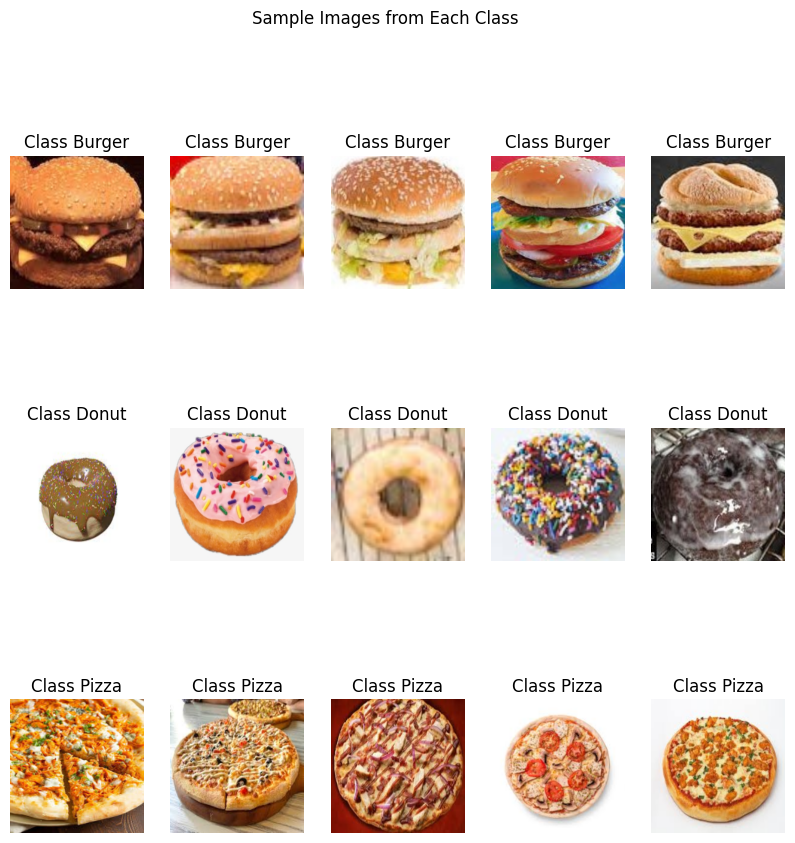

In [ ]:
# Plot 5 images untuk tiap class
plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i * 5 + j + 1)
        plt.imshow(images[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

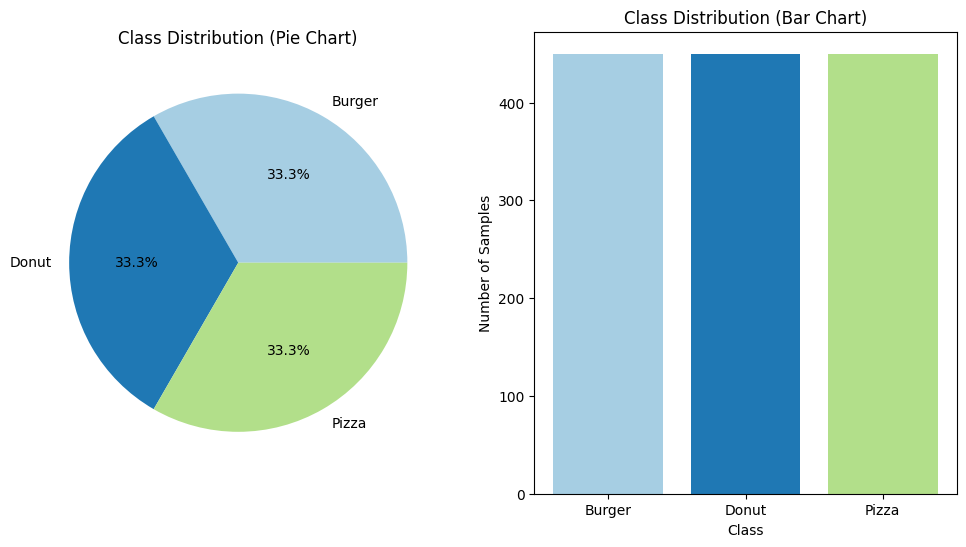

In [ ]:
# Plot class distribution (pie chart dan bar chart)
class_counts = np.bincount(labels)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(class_counts, labels=subfolders, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
plt.bar(subfolders, class_counts, color=plt.cm.Paired.colors)
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.show()

## **SPLIT DATASET**

In [ ]:
# One-hot encode the labels
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(subfolders))

# Split data ke training dan testing set
x_train, x_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

Di sini saya membagi dataset menjadi training set dan testing set, dengan 20% data dialokasikan untuk testing set, dan sisanya 80% untuk training set.

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1080, 224, 224, 3) (1080, 3)
(270, 224, 224, 3) (270, 3)


## **BUILDING MODEL**

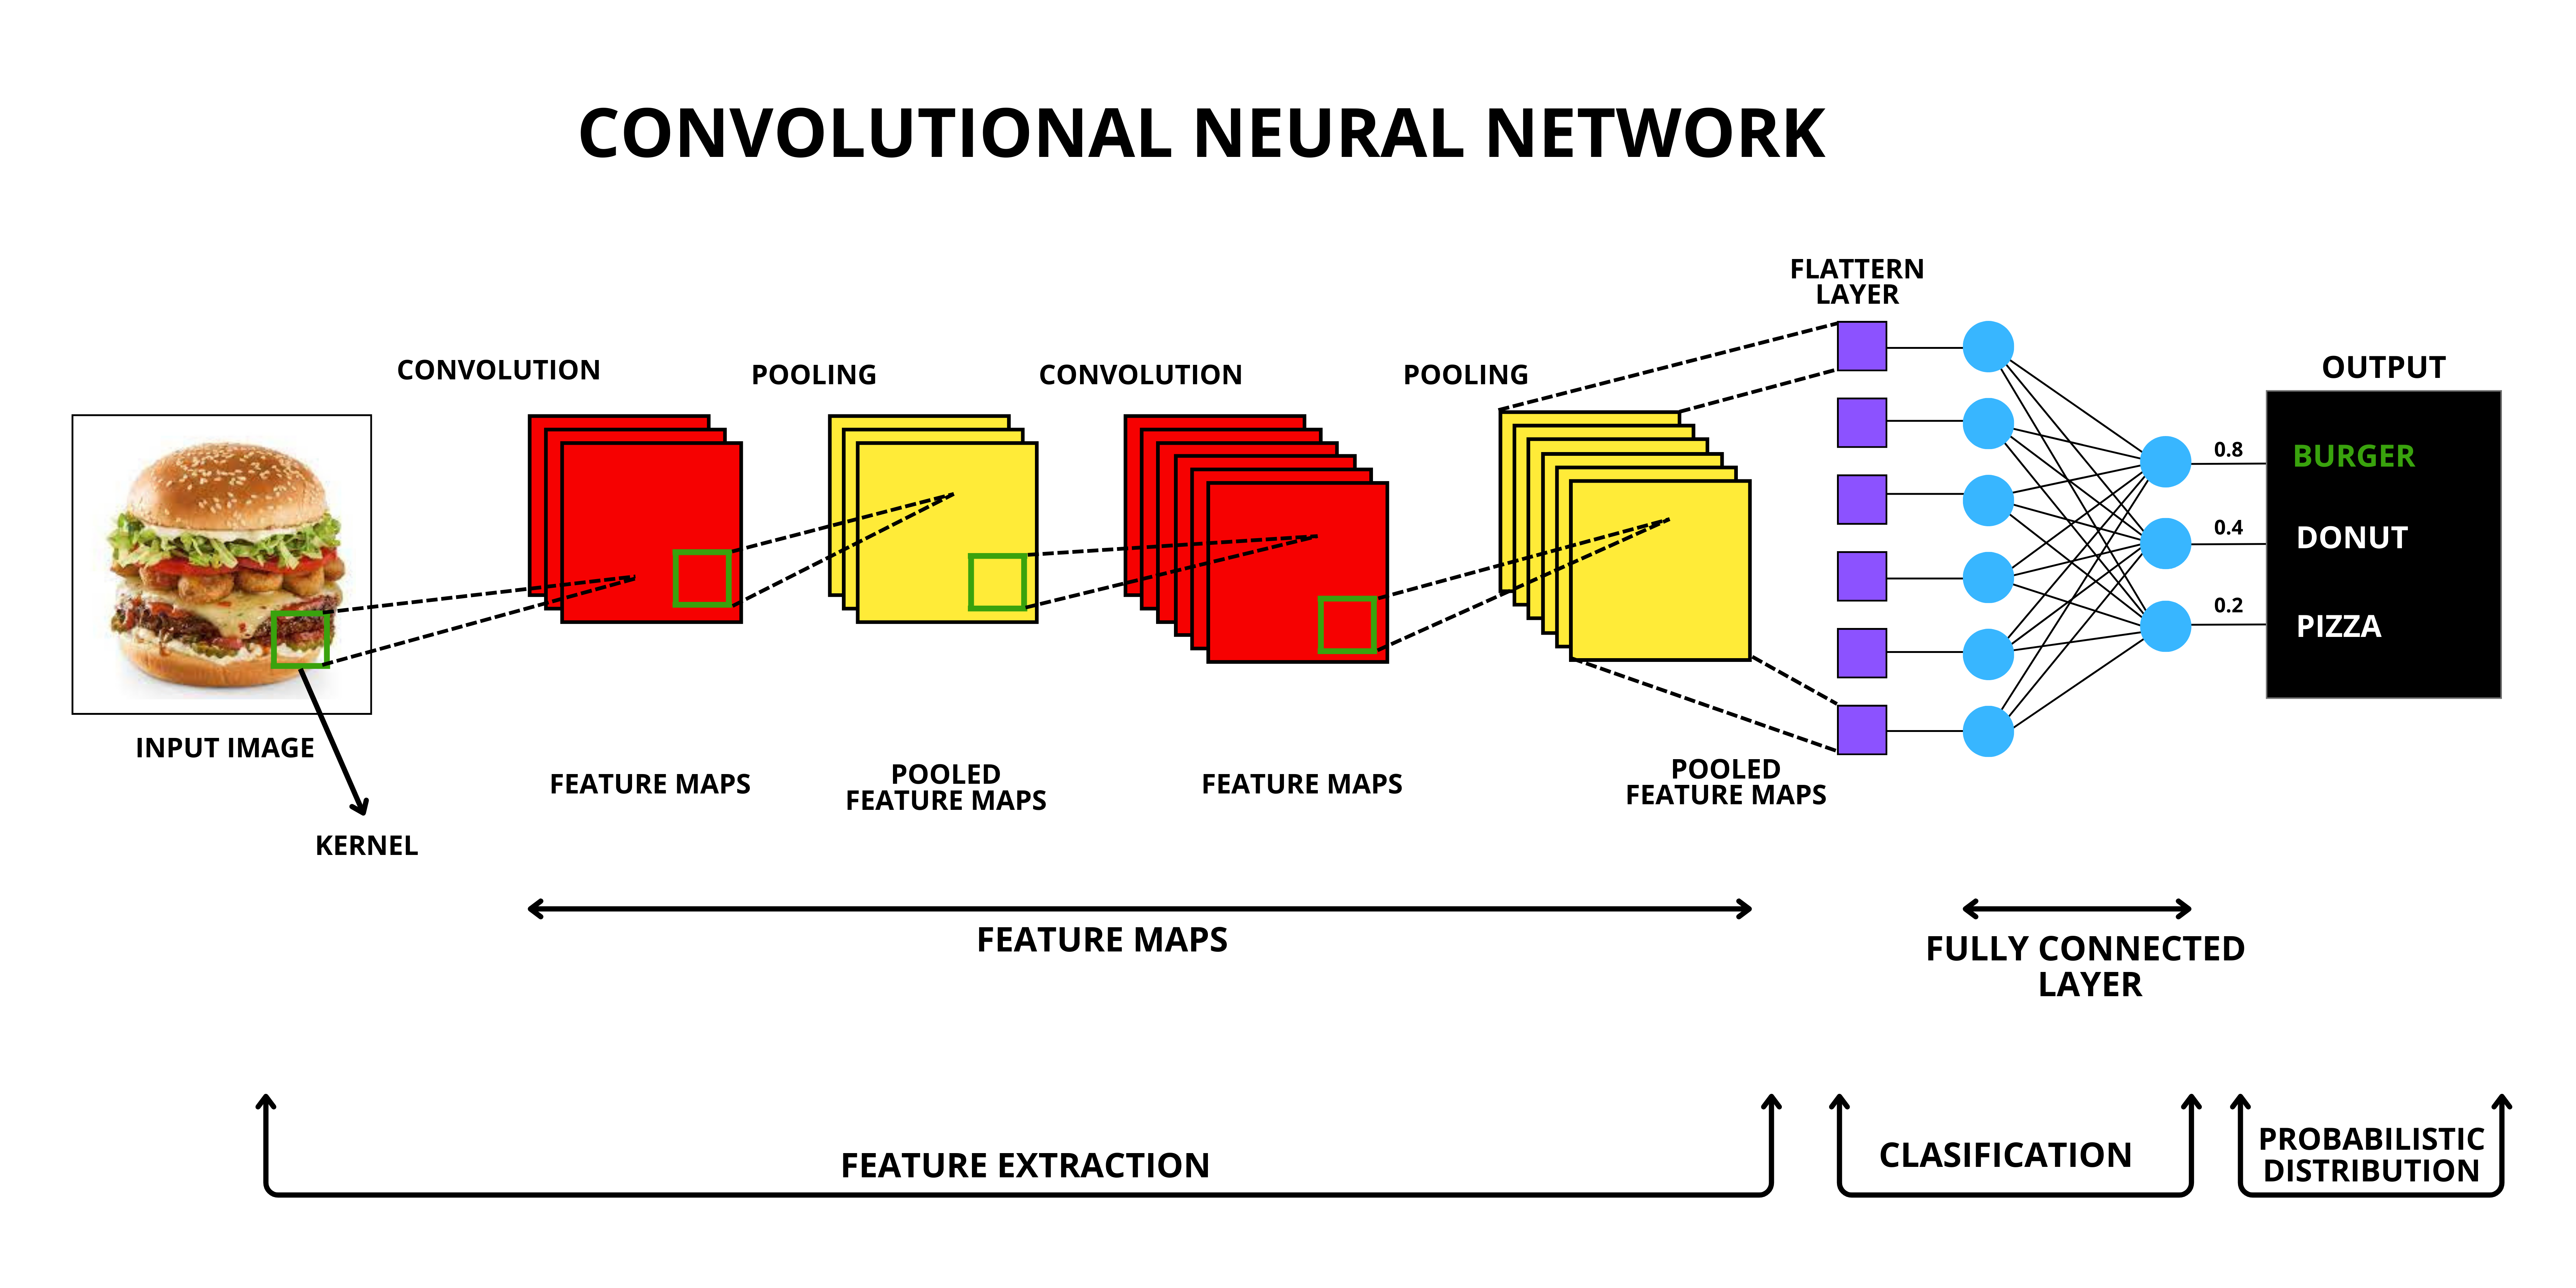

Berdasarkan arsitektur CNN di atas, berikut spesifikasi model CNN yang akan saya bangun:
* Convolutional Layer: Model memiliki 3 lapisan konvolusi dengan jumlah filter 64, 64, dan 128. Setiap lapisan menggunakan kernel 3x3 dan fungsi aktivasi ReLU untuk menangkap pola fitur dari gambar.

* Lapisan Pooling (MaxPooling): MaxPooling2D diterapkan setelah setiap layer convolusi  untuk mereduksi dimensi fitur. Pooling menggunakan ukuran 2x2.

* Dropout: Dropout diterapkan setelah pooling dengan rasio dropout 0.25 dan sebelum lapisan fully connected dengan rasio 0.1 untuk mencegah overfitting. Dropout secara acak menonaktifkan beberapa neuron selama pelatihan.

* Lapisan Fully Connected (Dense Layers): Lapisan Flatten mengubah data fitur yang berbentuk matriks menjadi bentuk vektor satu dimensi agar dapat diproses oleh lapisan berikutnya. Setelah itu, lapisan Dense(128, ReLU) menghubungkan semua fitur yang telah diekstrak ke 128 neuron untuk mengolah informasi lebih lanjut. Terakhir, lapisan Dense(3, Softmax) menghasilkan output berupa probabilitas untuk setiap kelas (sesuai jumlah kelas dalam dataset), sehingga model dapat menentukan gambar termasuk ke kelas mana.

* Optimisasi: Model menggunakan Adam optimizer dan categorical_crossentropy sebagai fungsi loss untuk klasifikasi multi-kelas. metrik evaluasi yang digunakan adalah accuracy.

In [ ]:
# Membangun model CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Tambah Dropout setelah pooling layer pertama

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Tambah Dropout setelah pooling layer kedua

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Tambah Dropout setelah pooling layer ketiga

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # Tambah Dropout sebelum dense layer terakhir.

    tf.keras.layers.Dense(len(subfolders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,188,675 (42.68 MB)

 Trainable params: 11,188,675 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Training model dan menyimpan history training
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.3069 - loss: 3.6392 - val_accuracy: 0.3593 - val_loss: 1.0979
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 272s 7s/step - accuracy: 0.4321 - loss: 1.0747 - val_accuracy: 0.5630 - val_loss: 0.9830
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 259s 7s/step - accuracy: 0.5809 - loss: 0.9139 - val_accuracy: 0.5926 - val_loss: 0.8903
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.7279 - loss: 0.6891 - val_accuracy: 0.7815 - val_loss: 0.5251
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - accuracy: 0.8381 - loss: 0.4478 - val_accuracy: 0.8259 - val_loss: 0.5062
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.8947 - loss: 0.2852 - val_accuracy: 0.8444 - val_loss: 0.4032
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9263 - loss: 0.2239 - val_accuracy: 0.8704 - val_loss: 0.3512
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9529 - loss: 0.1456 - val_accuracy: 0.8630 - v

## **EVALUASI MODEL**

In [ ]:
# Evaluasi model pada test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9056 - loss: 0.3123
Test accuracy: 0.9037036895751953
Test loss: 0.36876773834228516


di sini dilakukan evaluasi model dengan menggunakan data test untuk mengukur seberapa baik model yang sudah dilatih dalam memprediksi data yang belum pernah dilihat sebelumnya.
pada hasil diatas akurasi untuk data test adalah 90% berarti model berhasil memprediksi kelas dengan benar sekitar 90% dari data uji yang belum pernah dilihat sebelumnya.

In [ ]:
# Classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders))

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

      Burger       0.87      0.93      0.90        91
       Donut       0.91      0.96      0.94        85
       Pizza       0.94      0.82      0.88        94

    accuracy                           0.90       270
   macro avg       0.91      0.91      0.90       270
weighted avg       0.91      0.90      0.90       270



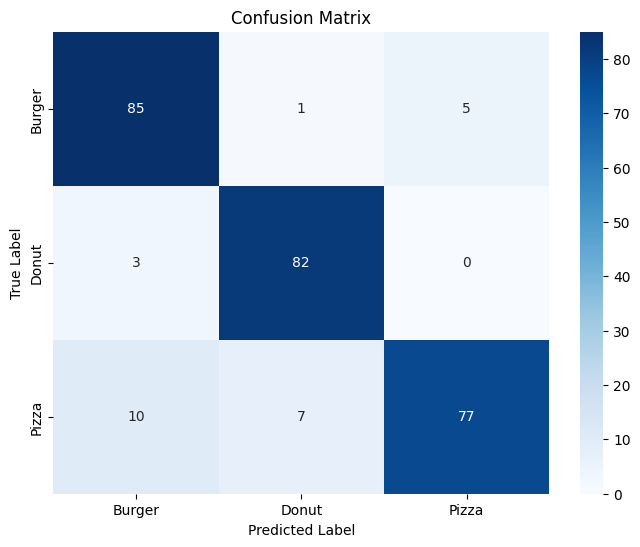

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

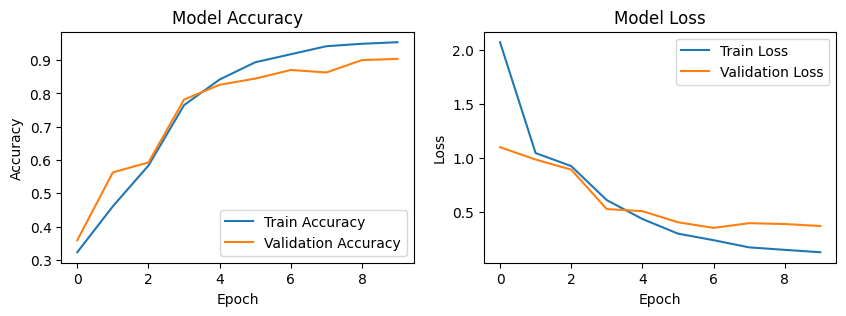

In [ ]:
# Plot history akurasi dan loss model
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Dari grafik akurasi dan loss di atas, terlihat bahwa model tidak mengalami overfitting. Hal ini dapat dilihat dari performa akurasi training dan validasi yang terus meningkat secara konsisten, serta train loss dan validation loss yang terus menurun. Penurunan loss menunjukkan bahwa model berhasil mempelajari pola dari data secara efektif tanpa terlalu fokus pada detail yang spesifik untuk data training (overfitting). Kondisi ini menandakan bahwa model memiliki kemampuan generalisasi yang baik, sehingga dapat memberikan prediksi yang akurat pada data baru.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_and_display_results(model, images, true_labels, subfolders, num_images=4):
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        # memilih random image dari test set
        index = np.random.randint(0, len(images))
        sample_image = images[index]
        true_label = np.argmax(true_labels[index])

        # memprediksi probabilitas dari image tang dipilih
        predictions = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_label = np.argmax(predictions[0])

        # Format dan cetak probabilitas beserta label yang sesuai
        formatted_probabilities = [f'Label {subfolders[j]}: {prob:.4f}' for j, prob in enumerate(predictions[0])]

        # mencetak true label, predicted label, dan semua probabilitas
        print(f'Image {i + 1}:')
        print(f'True label: {subfolders[true_label]}')
        print(f'Predicted label: {subfolders[predicted_label]}')
        print('Probabilities for each class:')
        for label_prob in formatted_probabilities:
            print(label_prob)
        print()

         # menampilkan gambar
        plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_image)
        plt.title(f'True: {subfolders[true_label]}\nPredicted: {subfolders[predicted_label]}')
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Image 1:
True label: Burger
Predicted label: Burger
Probabilities for each class:
Label Burger: 0.9780
Label Donut: 0.0022
Label Pizza: 0.0198

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Image 2:
True label: Burger
Predicted label: Burger
Probabilities for each class:
Label Burger: 0.9912
Label Donut: 0.0060
Label Pizza: 0.0029

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Image 3:
True label: Pizza
Predicted label: Pizza
Probabilities for each class:
Label Burger: 0.0033
Label Donut: 0.0340
Label Pizza: 0.9627

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Image 4:
True label: Pizza
Predicted label: Pizza
Probabilities for each class:
Label Burger: 0.0234
Label Donut: 0.0239
Label Pizza: 0.9526

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Image 5:
True label: Donut
Predicted label: Donut
Probabilities for each class:
Label Burger: 0.0039
Label Donut: 0.9858
Label Pizza: 0.0103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Image 6:
True label: Pizza
Predicted label: Pizza
Pr

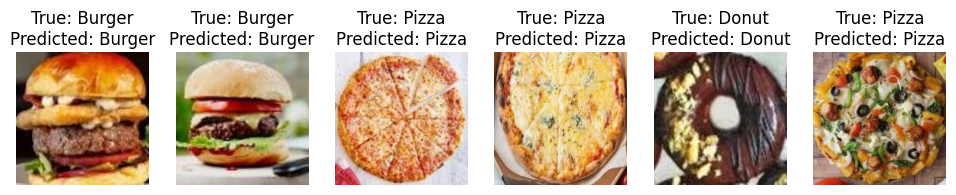

In [ ]:
# Uji fungsi dengan 5 gambar
predict_and_display_results(model, x_test, y_test, subfolders, num_images=6)